In [320]:
import pandas as pd
import numpy as np
## dataviz
import matplotlib.pyplot as plt
import seaborn as sns
## models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
## utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
# clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))
from sklearn.preprocessing import OneHotEncoder
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from sklearn.preprocessing import LabelEncoder

from fitter import Fitter, get_common_distributions, get_distributions

from scipy.stats.stats import pearsonr
import scipy
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.inspection import permutation_importance

c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RS = 42

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df_original = pd.read_csv('./data/treated/21_01_2023_20_08_24_pq_leiloes.csv',parse_dates=['auction_date'])

In [5]:
df_dec = df_original.drop(['auction_number','auction_item_lote','auction_item_type'#,'auction_date'
                           ,'CÂMBIO MECÂNICO','FREIOS ABS',
                        'target_percentage','target_diff','auction_item_highest_bid','BLINDAGEM'],
                axis=1).copy()
df_dec = df_dec.loc[df_dec['perc_dec'] >= 0]

In [6]:
df_dec = df_dec.dropna(subset=['perc_dec'])

In [7]:
df_dec.head(5)

,auction_item_min_bid_value,auction_item_brand,auction_item_market_price,auction_item_color,auction_item_gas_type,auction_item_km,auction_date,AIR BAG,ALARME,AR CONDICIONADO,CÂMBIO AUTOMÁTICO,DIREÇÃO HIDRÁULICA,TETO SOLAR,VIDRO ELÉTRICO,model_name,SEM_CHAVE,TRINCADO,AVARIADO,SINISTRO,item_age,perc_dec
0,12500.0,VW,28092.0,BRANCA,FLEX,90790.0,NaT,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NOVO,0.0,0.0,0.0,0.0,NaN,55.503346
1,11500.0,FIAT,25613.0,PRATA,FLEX,113718.0,NaT,0.0,0.0,1.0,0.0,1.0,0.0,1.0,UNO,0.0,0.0,0.0,0.0,NaN,55.100925
2,16000.0,CITROËN,36027.0,BRANCA,FLEX,119262.0,NaT,1.0,0.0,1.0,0.0,1.0,0.0,1.0,C3,0.0,0.0,1.0,0.0,NaN,55.588864
3,37500.0,FORD,83601.0,CINZA,FLEX,154564.0,NaT,1.0,0.0,1.0,0.0,1.0,0.0,1.0,RANGER,0.0,0.0,0.0,0.0,NaN,55.144077
4,17500.0,HYUNDAY,39484.0,PRATA,GASOLINA,149446.0,NaT,1.0,1.0,1.0,1.0,1.0,0.0,1.0,TUCSON,0.0,0.0,1.0,0.0,NaN,55.678249


## Analise Univariada

<AxesSubplot:>

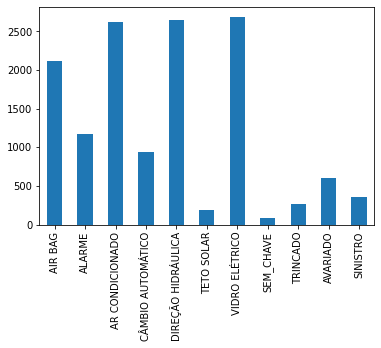

In [8]:
df_dec[['AIR BAG', 'ALARME', 'AR CONDICIONADO',
       'CÂMBIO AUTOMÁTICO', 'DIREÇÃO HIDRÁULICA', 'TETO SOLAR',
       'VIDRO ELÉTRICO', 'SEM_CHAVE', 'TRINCADO', 'AVARIADO', 'SINISTRO']].sum().plot(kind='bar')

Text(0, 0.5, 'Quantidade')

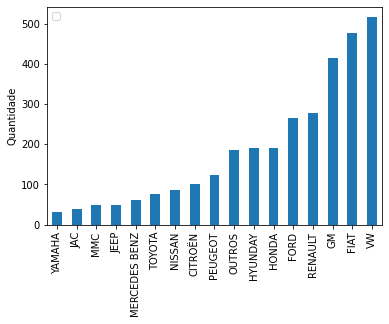

In [10]:
df_brands = pd.DataFrame(df_dec.auction_item_brand.value_counts()).reset_index()
df_brands.columns=['auction_item_brand','qtd']
df_brands['brand_name'] = np.where(df_brands.qtd>30,df_brands.auction_item_brand,'OUTROS')
df_brands.groupby('brand_name').qtd.sum().reset_index().sort_values('qtd').set_index('brand_name').plot(kind='bar')
plt.legend('')
plt.xlabel('')
plt.ylabel('Quantidade')

In [11]:
## Setting a minimum number of brands 30
df_brands = pd.DataFrame(df_dec.auction_item_brand.value_counts()).reset_index()
df_brands.columns=['auction_item_brand','qtd']
df_brands['brand_name'] = np.where(df_brands.qtd>30,df_brands.auction_item_brand,'OUTROS')
df_brands = df_brands.drop(['qtd'],axis=1)
df_dec = df_dec.merge(df_brands,on='auction_item_brand',how='left')
df_dec = df_dec.drop(['auction_item_brand'],axis=1)

In [12]:
df_brands.brand_name.nunique()

17

In [13]:
## Replacing values that are rare
df_dec['auction_item_gas_type'] = np.where(df_dec['auction_item_gas_type'].isin(['GAS/ALC/GNV','-','ALCOOL','GÁS','GASOLINA/GNV']),
                                            'FLEX',df_dec['auction_item_gas_type'])

Text(0, 0.5, 'Quantidade')

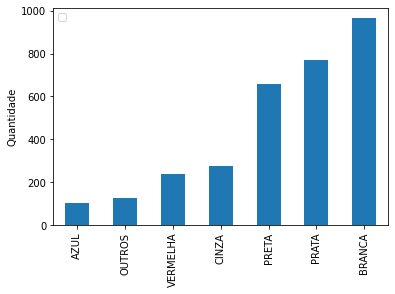

In [14]:
## Setting a minimum number of colors 50
df_colors = pd.DataFrame(df_dec.auction_item_color.value_counts()).reset_index()
df_colors.columns=['auction_item_color','qtd']
df_colors['color'] = np.where(df_colors.qtd>50,df_colors.auction_item_color,'OUTROS')
df_colors.groupby('color').qtd.sum().reset_index().sort_values('qtd').set_index('color').plot(kind='bar')
plt.legend('')
plt.xlabel('')
plt.ylabel('Quantidade')

In [15]:
df_colors = df_colors.drop(['qtd'],axis=1)
df_dec = df_dec.merge(df_colors,on='auction_item_color',how='left')
df_dec = df_dec.drop(['auction_item_color'],axis=1)



Text(0, 0.5, 'Quantidade')

<Figure size 1440x720 with 0 Axes>

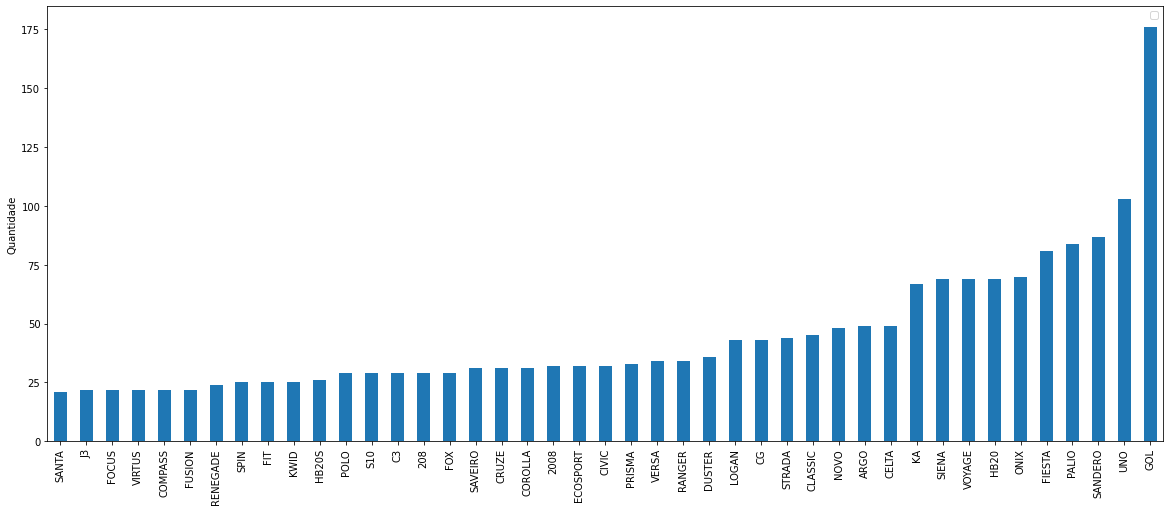

In [16]:
## Setting a minimum number of models 20
df_models = pd.DataFrame(df_dec.model_name.value_counts()).reset_index()
df_models.columns=['model_name','qtd']
df_models['model'] = np.where(df_models.qtd>20,df_models.model_name,'OUTROS')

plt.figure(figsize=(20,10))
df_models.loc[df_models.model!='OUTROS'].groupby('model').qtd.sum().reset_index().sort_values('qtd').set_index('model').plot(kind='bar',figsize=(20,8))
plt.legend('')
plt.xlabel('')
plt.ylabel('Quantidade')

In [17]:
df_models = df_models.drop(['qtd'],axis=1)
df_dec = df_dec.merge(df_models,on='model_name',how='left')
df_dec = df_dec.drop(['model_name'],axis=1)

Text(0, 0.5, 'Quantidade')

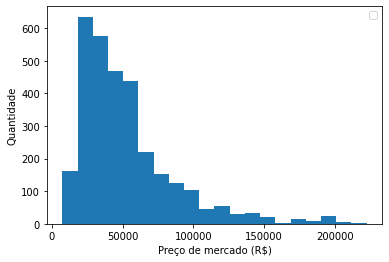

In [19]:

df_dec.loc[(df_dec.auction_item_market_price<250_000)].auction_item_market_price.plot(kind='hist',bins=20)
plt.legend('')
plt.xlabel('Preço de mercado (R$)')
plt.ylabel('Quantidade')

Text(0, 0.5, 'Quantidade')

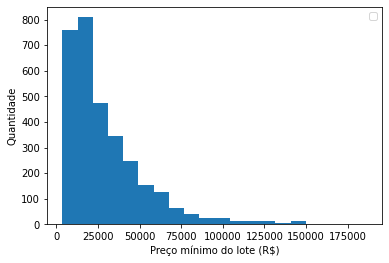

In [20]:

df_dec.loc[(df_dec.auction_item_min_bid_value<250_000)].auction_item_min_bid_value.plot(kind='hist',bins=20)
plt.legend('')
plt.xlabel('Preço mínimo do lote (R$)')
plt.ylabel('Quantidade')

Text(0, 0.5, 'Quantidade')

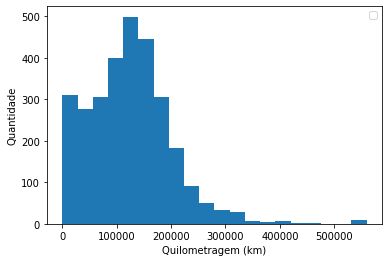

In [21]:

df_dec.loc[(df_dec.auction_item_km<900_000)].auction_item_km.plot(kind='hist',bins=20)
plt.legend('')
plt.xlabel('Quilometragem (km)')
plt.ylabel('Quantidade')

Text(0, 0.5, 'Quantidade')

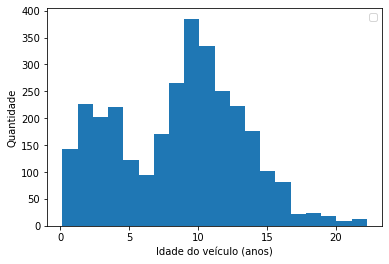

In [22]:

df_dec.loc[(df_dec.item_age>0)].item_age.plot(kind='hist',bins=20)
plt.legend('')
plt.xlabel('Idade do veículo (anos)')
plt.ylabel('Quantidade')

### Análise Bivariada

Text(0.5, 1.0, 'Cor X Desvalorização')

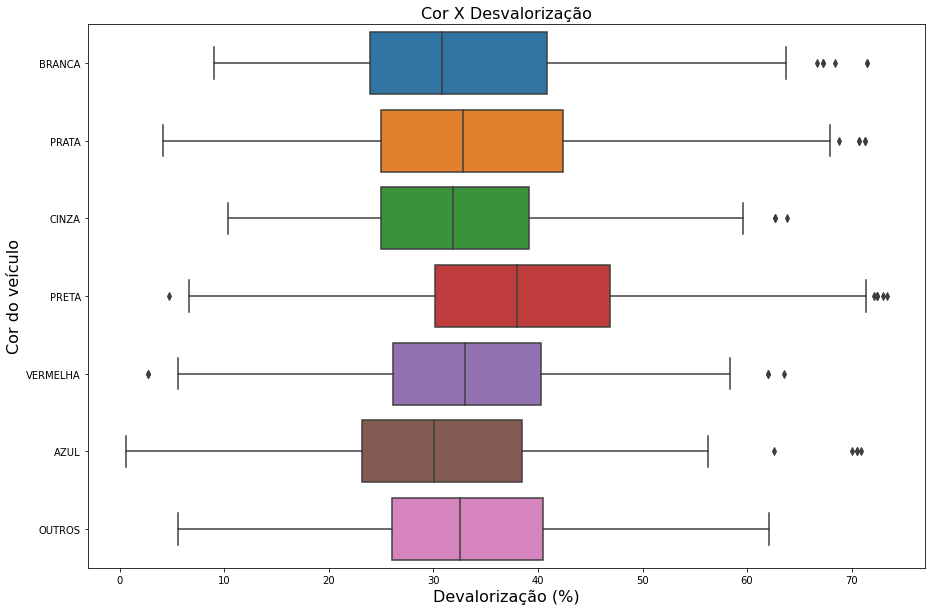

In [23]:
## Valor percentual abaixo do mercado por kms rodados do último leilão por cor do carro
plt.figure(figsize=(15,10))
sns.boxplot(x='perc_dec', y='color', data=df_dec)
plt.xlabel('Devalorização (%)', fontsize=16)
plt.ylabel('Cor do veículo', fontsize=16)
plt.title('Cor X Desvalorização', fontsize=16)

Text(0.5, 1.0, 'Marca X Desvalorização')

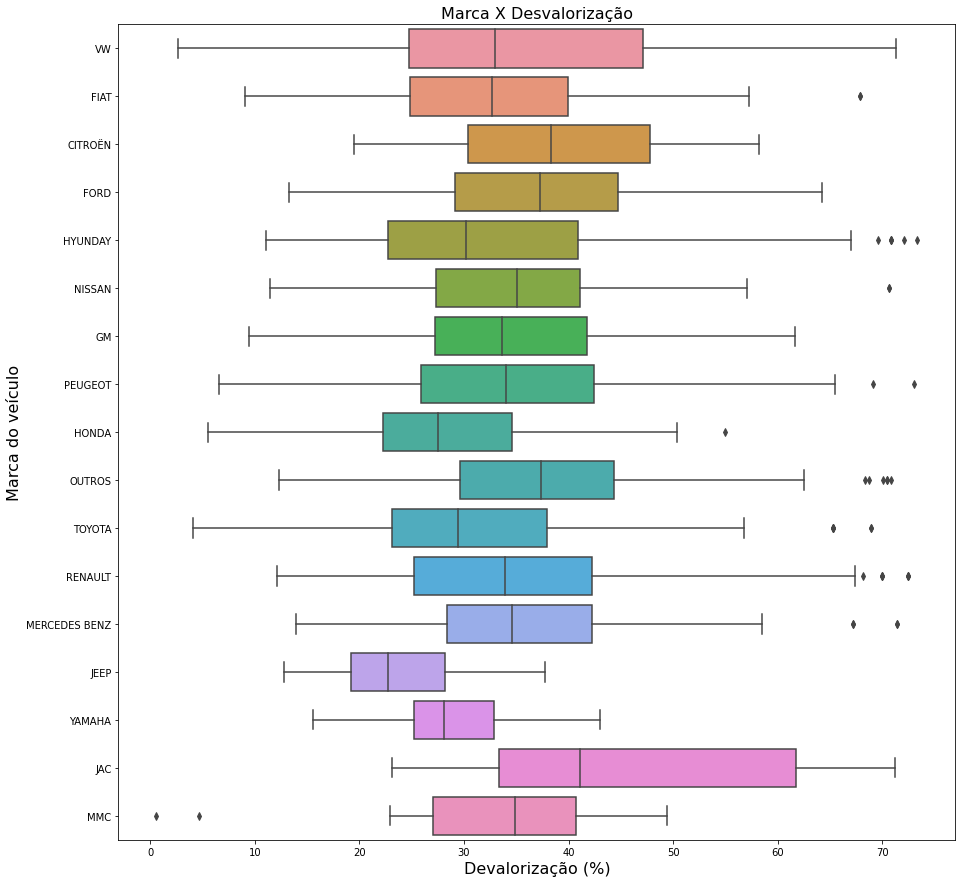

In [24]:
## Valor percentual abaixo do mercado por kms rodados do último leilão por marca de carro
plt.figure(figsize=(15,15))
sns.boxplot(x='perc_dec', y='brand_name', data=df_dec)
plt.xlabel('Devalorização (%)', fontsize=16)
plt.ylabel('Marca do veículo', fontsize=16)
plt.title('Marca X Desvalorização', fontsize=16)

AIR BAG
ALARME
AR CONDICIONADO
CÂMBIO AUTOMÁTICO
DIREÇÃO HIDRÁULICA
TETO SOLAR
VIDRO ELÉTRICO
SEM_CHAVE
TRINCADO
AVARIADO
SINISTRO


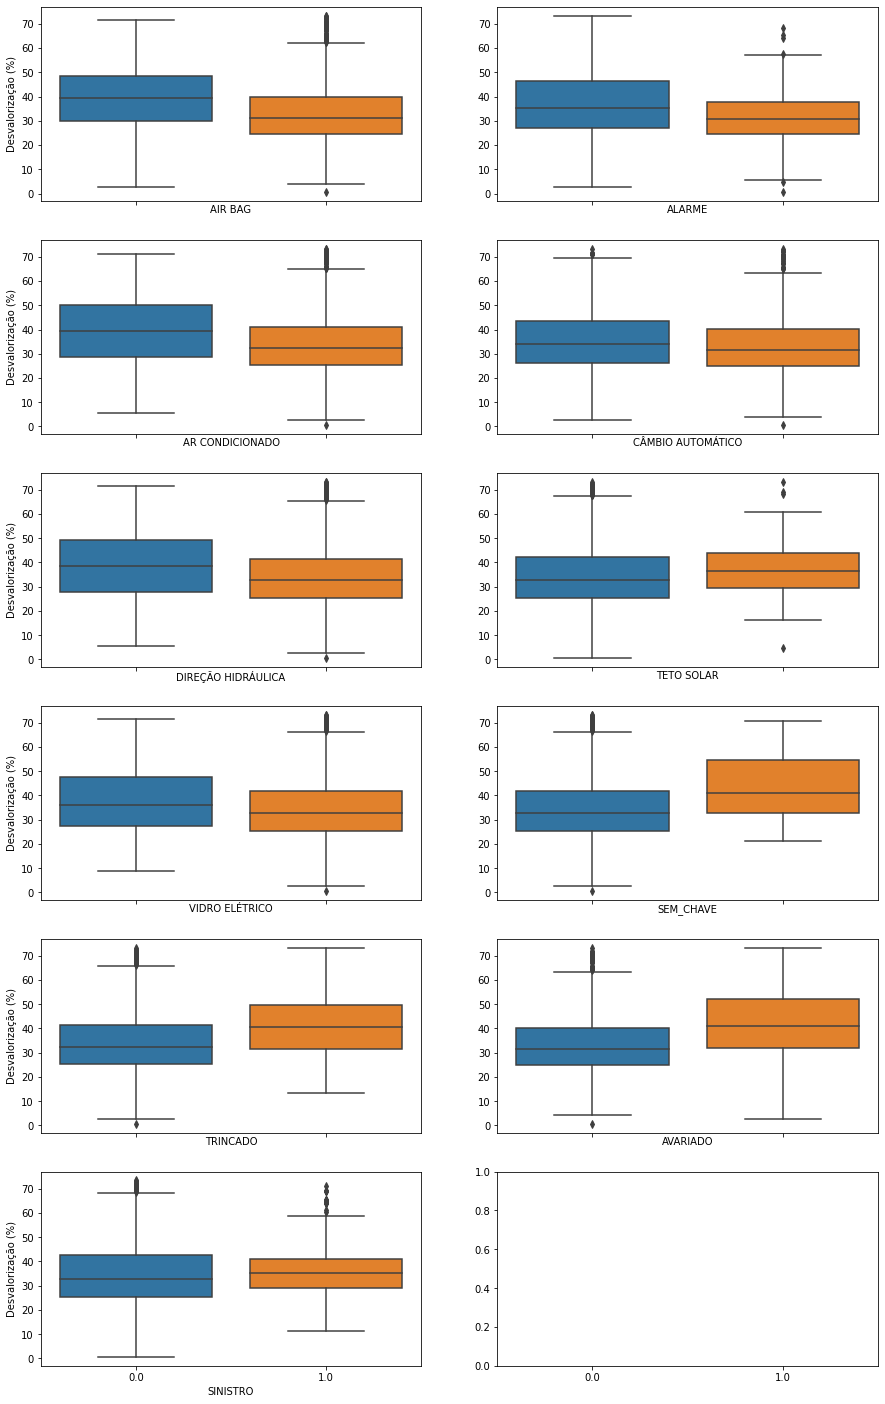

In [30]:
fig, axes = plt.subplots(6, 2, figsize=(15, 25),sharex=True, sharey=False)
# fig.suptitle('Desvalorização relativa as características')
columns_cat = ['AIR BAG', 'ALARME', 'AR CONDICIONADO','CÂMBIO AUTOMÁTICO', 'DIREÇÃO HIDRÁULICA', 'TETO SOLAR', 'VIDRO ELÉTRICO', 'SEM_CHAVE', 'TRINCADO', 'AVARIADO', 'SINISTRO']
for i,c in enumerate(columns_cat):
    print(c)
    sns.boxplot(ax=axes[int(i/2),i%2],x=c, y='perc_dec',data = df_dec)
    if i%2 == 1:
        axes[int(i/2),i%2].set_ylabel('')
    else:
        axes[int(i/2),i%2].set_ylabel('Desvalorização (%)')

Text(0.5, 1.0, 'Marca X Desvalorização')

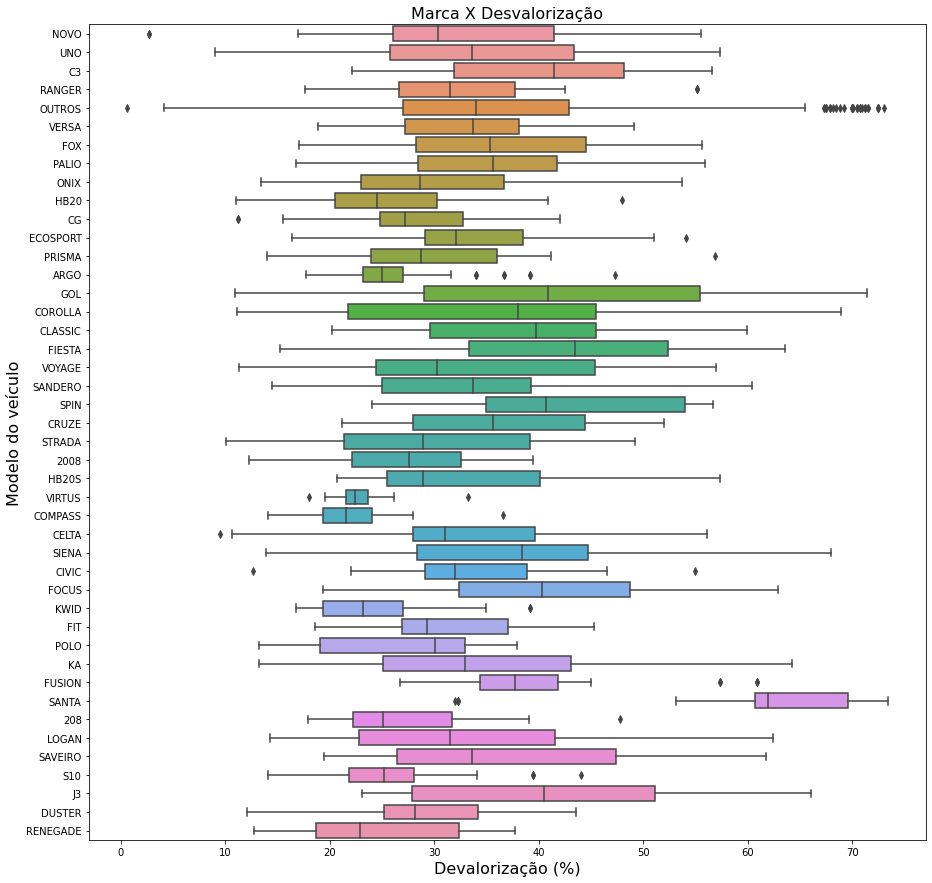

In [31]:
## Valor percentual abaixo do mercado por kms rodados do último leilão por cor do carro por marca de carro
plt.figure(figsize=(15,15))
sns.boxplot(x='perc_dec', y='model', data=df_dec)
plt.xlabel('Devalorização (%)', fontsize=16)
plt.ylabel('Modelo do veículo', fontsize=16)
plt.title('Marca X Desvalorização', fontsize=16)

Text(0.5, 1.0, 'Marca X Desvalorização')

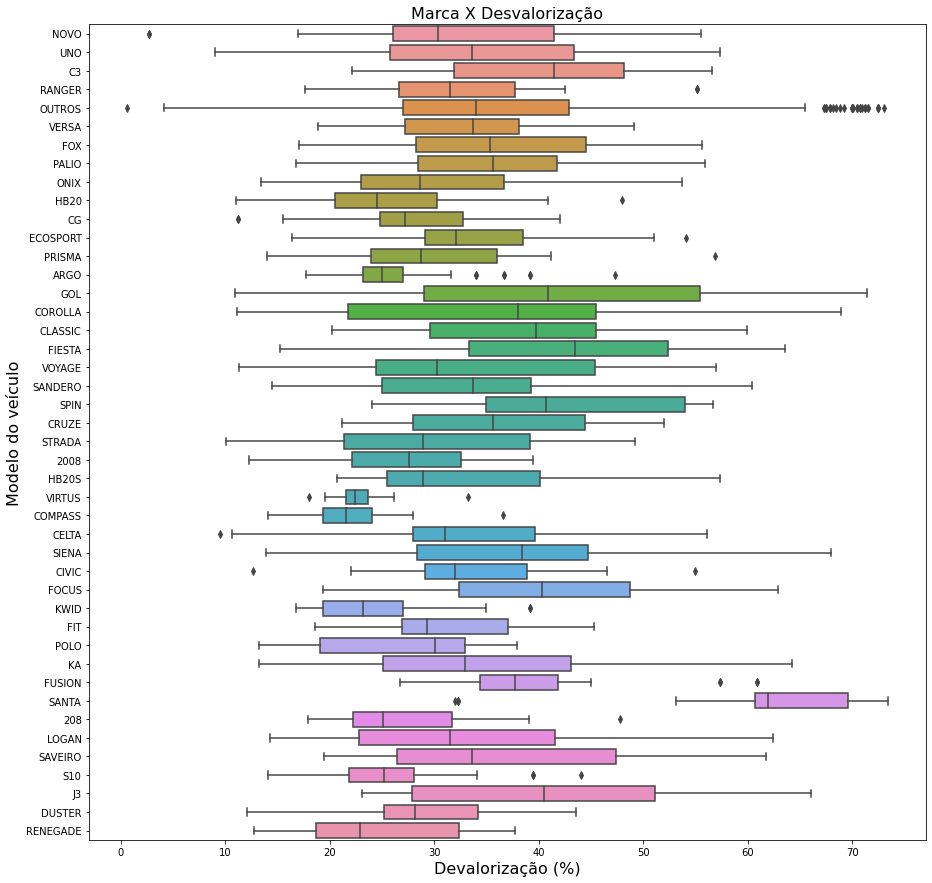

In [32]:
## Valor desvalorização por modelo
plt.figure(figsize=(15,15))
sns.boxplot(x='perc_dec', y='model', data=df_dec)
plt.xlabel('Devalorização (%)', fontsize=16)
plt.ylabel('Modelo do veículo', fontsize=16)
plt.title('Marca X Desvalorização', fontsize=16)

Text(0.5, 1.0, 'Rodagem dos veículos')

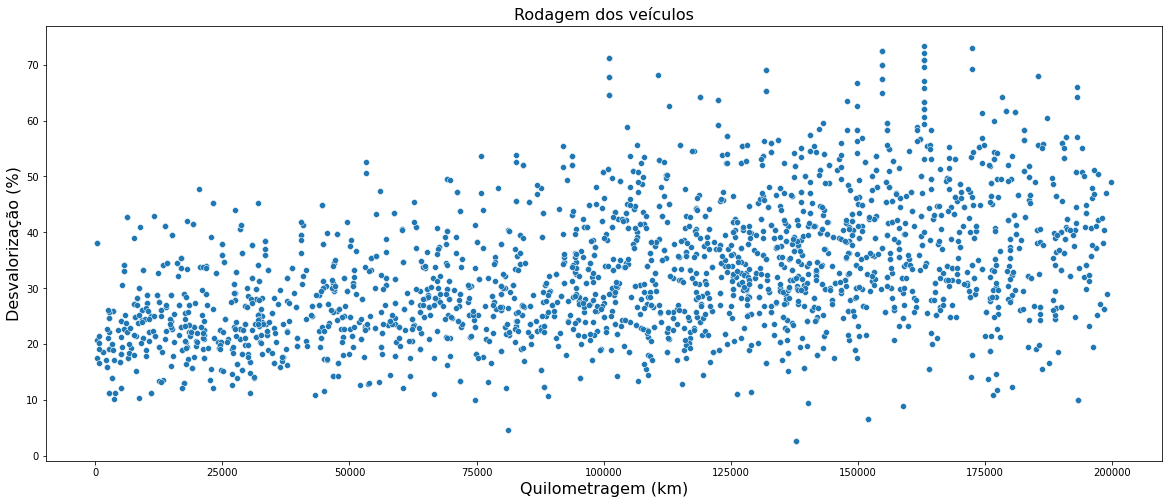

In [33]:
##Relação entre valor de mercado e valor mínimo do lote
plt.figure(figsize=(20,8))
sns.scatterplot(data = df_dec.loc[(df_dec.item_age > 0 ) & ( df_dec.auction_item_km< 200_000)],
               x='auction_item_km',y='perc_dec')
plt.xlabel('Quilometragem (km)', fontsize=16)
plt.ylabel('Desvalorização (%)', fontsize=16)
plt.title('Rodagem dos veículos', fontsize=16)

In [34]:
#calculation correlation coefficient and p-value between x and y
pearsonr(df_dec.dropna(subset=['auction_item_km','perc_dec']).auction_item_km, df_dec.dropna(subset=['auction_item_km','perc_dec']).perc_dec)

(0.31457668976996184, 5.1547344129638e-69)

Text(0.5, 1.0, 'Rodagem dos veículos')

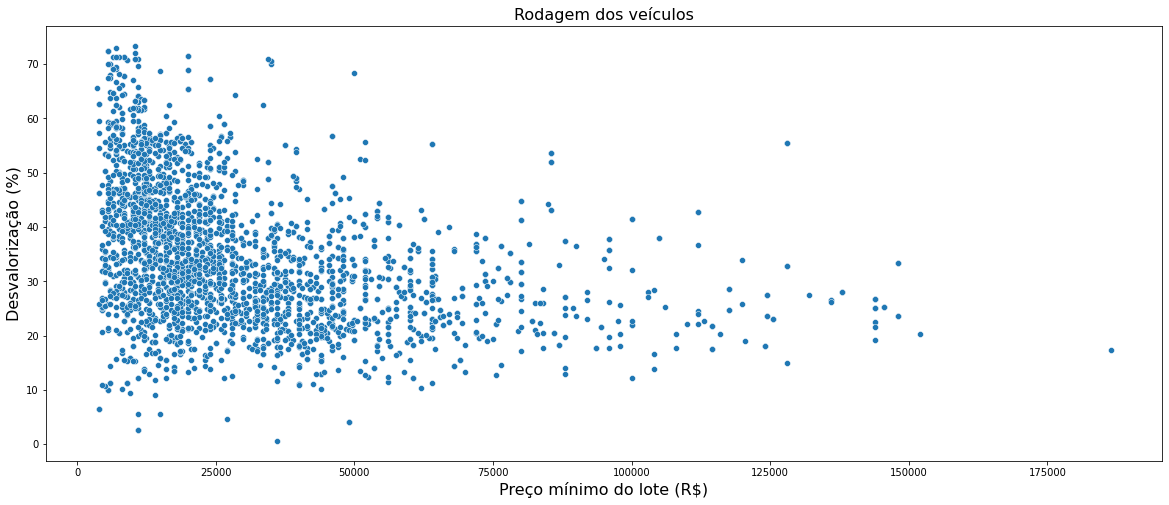

In [35]:
##Relação entre valor de mercado e valor mínimo do lote
plt.figure(figsize=(20,8))
sns.scatterplot(data = df_dec.loc[(df_dec.auction_item_min_bid_value<250_000)],
               x='auction_item_min_bid_value',y='perc_dec')
plt.xlabel('Preço mínimo do lote (R$)', fontsize=16)
plt.ylabel('Desvalorização (%)', fontsize=16)
plt.title('Rodagem dos veículos', fontsize=16)

In [36]:
#calculation correlation coefficient and p-value between x and y
pearsonr(df_dec.dropna(subset=['auction_item_min_bid_value','perc_dec']).auction_item_min_bid_value, df_dec.dropna(subset=['auction_item_min_bid_value','perc_dec']).perc_dec)

(-0.2754912765931791, 1.1638387021780308e-55)

Text(0.5, 1.0, 'Rodagem dos veículos')

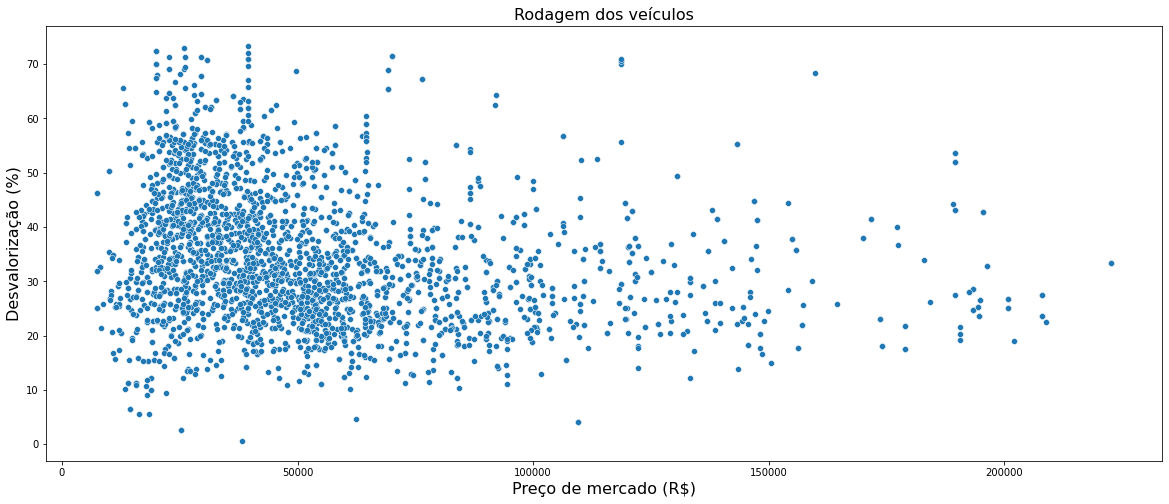

In [37]:
##Relação entre valor de mercado e valor mínimo do lote
plt.figure(figsize=(20,8))
sns.scatterplot(data = df_dec.loc[(df_dec.auction_item_market_price<250_000)],
               x='auction_item_market_price',y='perc_dec')
plt.xlabel('Preço de mercado (R$)', fontsize=16)
plt.ylabel('Desvalorização (%)', fontsize=16)
plt.title('Rodagem dos veículos', fontsize=16)

In [38]:
#calculation correlation coefficient and p-value between x and y
pearsonr(df_dec.dropna(subset=['auction_item_market_price','perc_dec']).auction_item_market_price, df_dec.dropna(subset=['auction_item_market_price','perc_dec']).perc_dec)

(-0.16667593746170656, 6.004148609184075e-21)

Text(0.5, 1.0, 'Rodagem dos veículos')

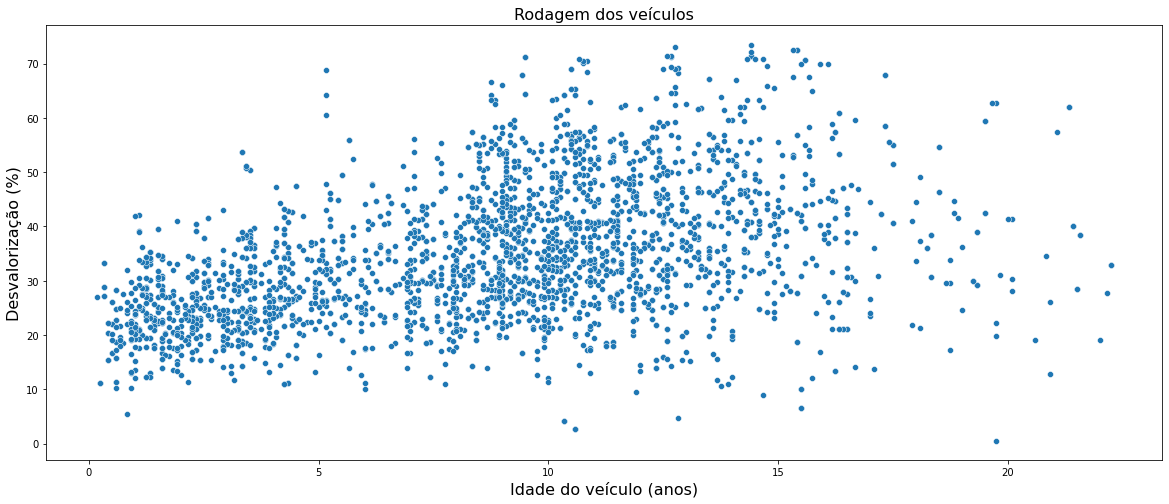

In [39]:

plt.figure(figsize=(20,8))
sns.scatterplot(data = df_dec.loc[(df_dec.item_age>0)],
               x='item_age',y='perc_dec')
plt.xlabel('Idade do veículo (anos)', fontsize=16)
plt.ylabel('Desvalorização (%)', fontsize=16)
plt.title('Rodagem dos veículos', fontsize=16)

In [40]:
#calculation correlation coefficient and p-value between x and y
pearsonr(df_dec.dropna(subset=['item_age','perc_dec']).item_age, df_dec.dropna(subset=['item_age','perc_dec']).perc_dec)

(0.27531603289317225, 2.7957681935946103e-55)

In [41]:
corr = df_dec.rename({'perc_dec':'desvalorizacao'}, axis=1).corr()

Text(0.5, 1.0, 'Correlação')

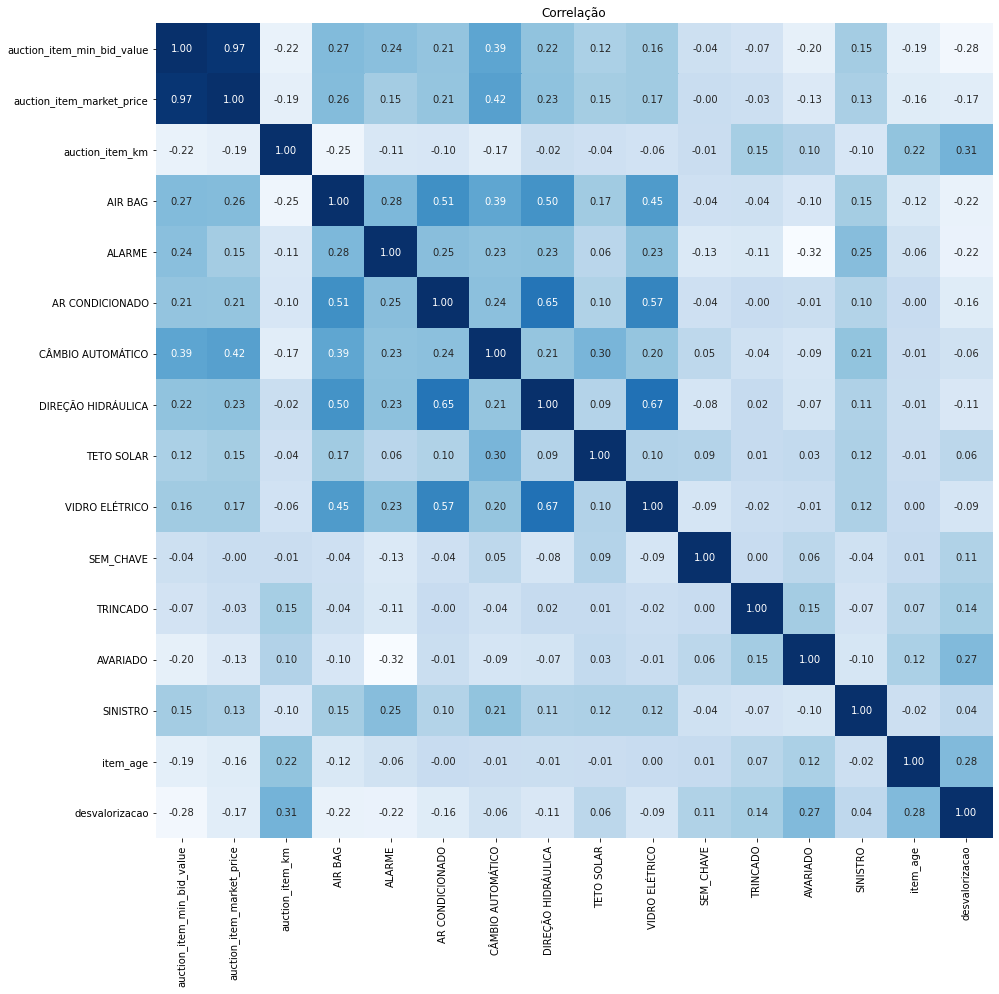

In [42]:
plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap="Blues", annot=True, cbar=False,fmt='.2f')
plt.title('Correlação')

### Analysing Y distribution

In [ ]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)

Text(0.5, 0, 'Descontro percentual com relação ao valor de mercado')

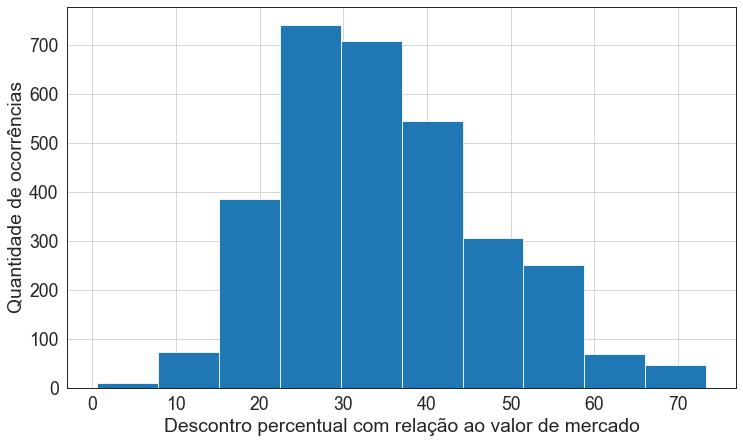

In [ ]:
plt.figure(figsize=(12,7))
df_dec.perc_dec.hist()
plt.ylabel('Quantidade de ocorrências')
plt.xlabel('Descontro percentual com relação ao valor de mercado')

<AxesSubplot:xlabel='auction_date', ylabel='perc_dec'>

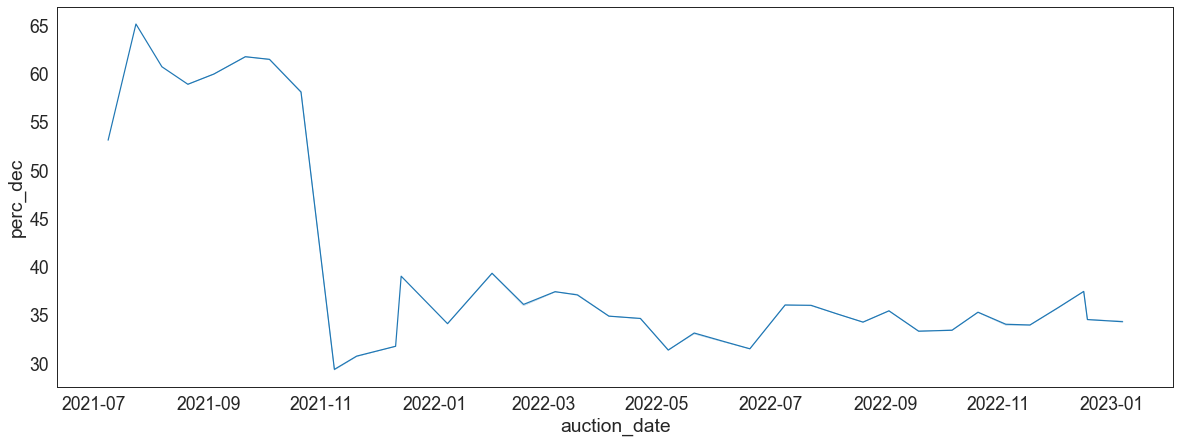

In [ ]:
plt.figure(figsize=(20,7))
sns.lineplot(data=df_dec,x='auction_date', y='perc_dec',ci=False)

<AxesSubplot:xlabel='auction_date', ylabel='perc_dec'>

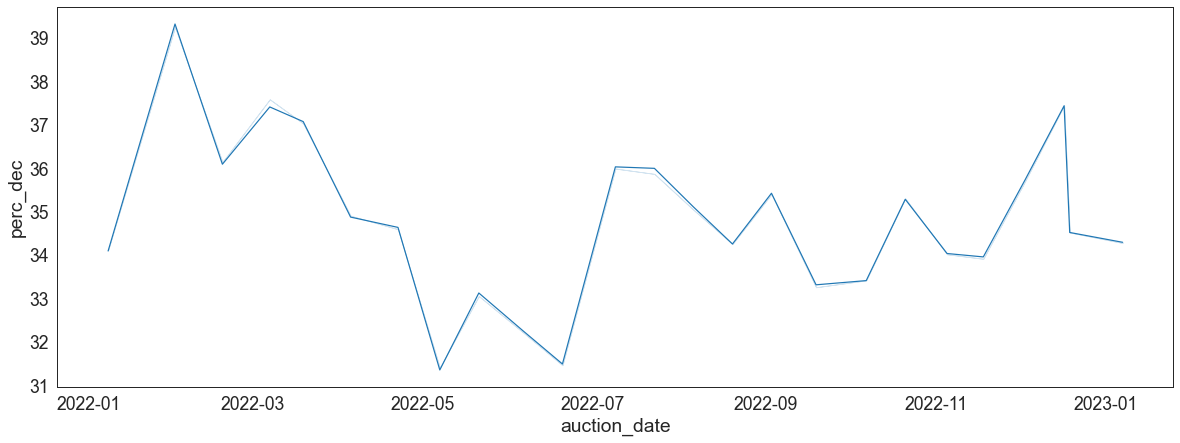

In [ ]:
plt.figure(figsize=(20,7))
sns.lineplot(data=df_dec.loc[df_dec.auction_date>'2022-01-01'],x='auction_date', y='perc_dec',ci=False)

Text(0.5, 0, 'Descontro percentual com relação ao valor de mercado')

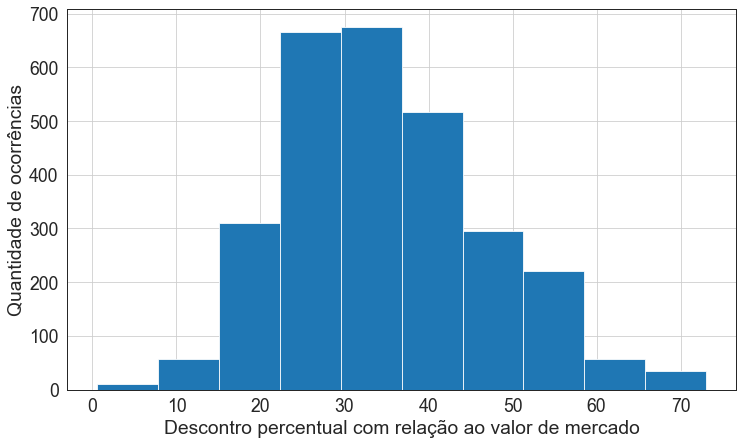

In [ ]:
plt.figure(figsize=(12,7))
df_dec.loc[df_dec.auction_date>'2022-01-01'].perc_dec.hist()
plt.ylabel('Quantidade de ocorrências')
plt.xlabel('Descontro percentual com relação ao valor de mercado')

In [55]:
##Teste de aderência a normalidade - D'Agostino e pearson
scipy.stats.normaltest(df_dec.perc_dec)

NormaltestResult(statistic=136.96756410400548, pvalue=1.810803623847142e-30)

In [56]:
##Teste de aderência a normalidade - Shapiro e Francia
scipy.stats.shapiro(df_dec.perc_dec)

(0.9768239855766296, 3.4772529269551e-22)

In [57]:
get_common_distributions()

['cauchy',
 'chi2',
 'expon',
 'exponpow',
 'gamma',
 'lognorm',
 'norm',
 'powerlaw',
 'rayleigh',
 'uniform']

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 12.81it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.001416,1017.061325,-45731.368026,inf,0.022583,8.196659e-02
gamma,0.001453,1019.345990,-45652.055742,inf,0.024487,4.674818e-02
chi2,0.001453,1019.345979,-45652.055494,inf,0.024487,4.674859e-02
norm,0.002668,982.771511,-43755.970752,inf,0.061368,1.137314e-10
cauchy,0.004317,992.732350,-42249.222809,inf,0.103962,7.916591e-30


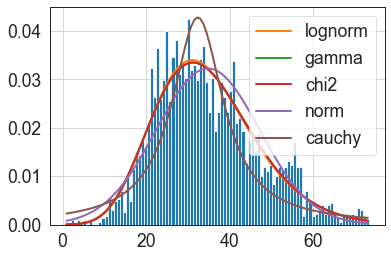

In [58]:
f = Fitter(df_dec.perc_dec,
           distributions= get_common_distributions())
f.fit()
f.summary()

In [59]:
df_dec = df_dec.drop(['auction_date'],axis=1)

### One Hot Encoding

In [43]:
df_dec = pd.get_dummies(df_dec, columns = ['brand_name',	'color',	'model' ,'auction_item_gas_type'],drop_first=True)

In [44]:
df_dec.head()

,auction_item_min_bid_value,auction_item_market_price,auction_item_km,auction_date,AIR BAG,ALARME,AR CONDICIONADO,CÂMBIO AUTOMÁTICO,DIREÇÃO HIDRÁULICA,TETO SOLAR,VIDRO ELÉTRICO,SEM_CHAVE,TRINCADO,AVARIADO,SINISTRO,item_age,perc_dec,brand_name_FIAT,brand_name_FORD,brand_name_GM,brand_name_HONDA,brand_name_HYUNDAY,brand_name_JAC,brand_name_JEEP,brand_name_MERCEDES BENZ,brand_name_MMC,brand_name_NISSAN,brand_name_OUTROS,brand_name_PEUGEOT,brand_name_RENAULT,brand_name_TOYOTA,brand_name_VW,brand_name_YAMAHA,color_BRANCA,color_CINZA,color_OUTROS,color_PRATA,color_PRETA,color_VERMELHA,model_208,model_ARGO,model_C3,model_CELTA,model_CG,model_CIVIC,model_CLASSIC,model_COMPASS,model_COROLLA,model_CRUZE,model_DUSTER,model_ECOSPORT,model_FIESTA,model_FIT,model_FOCUS,model_FOX,model_FUSION,model_GOL,model_HB20,model_HB20S,model_J3,model_KA,model_KWID,model_LOGAN,model_NOVO,model_ONIX,model_OUTROS,model_PALIO,model_POLO,model_PRISMA,model_RANGER,model_RENEGADE,model_S10,model_SANDERO,model_SANTA,model_SAVEIRO,model_SIENA,model_SPIN,model_STRADA,model_UNO,model_VERSA,model_VIRTUS,model_VOYAGE,auction_item_gas_type_FLEX,auction_item_gas_type_GASOLINA
0,12500.0,28092.0,90790.0,NaT,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,55.503346,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,11500.0,25613.0,113718.0,NaT,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,55.100925,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,16000.0,36027.0,119262.0,NaT,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,55.588864,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,37500.0,83601.0,154564.0,NaT,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,55.144077,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,17500.0,39484.0,149446.0,NaT,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,55.678249,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Filling missing

In [45]:
class filling_na():
    def __init__(self):
        self.parameter = {}

    def fit(self,df,y=None):
        ## Filling with mean value
        for c in ['auction_item_km','item_age']:
            self.parameter[c] = df[c].mean()
        ## Filling na with round mean value
        for c in ['AIR BAG','ALARME','AR CONDICIONADO','CÂMBIO AUTOMÁTICO','DIREÇÃO HIDRÁULICA','TETO SOLAR','VIDRO ELÉTRICO']:
            self.parameter[c] = round(df[c].mean())

    def fit_transform(self,df,y=None):
        ## Filling with mean value
        for c in ['auction_item_km','item_age']:
            self.parameter[c] = df[c].mean()
            df[c]  = df[c].fillna(self.parameter[c])
        ## Filling na with round mean value
        for c in ['AIR BAG','ALARME','AR CONDICIONADO','CÂMBIO AUTOMÁTICO','DIREÇÃO HIDRÁULICA','TETO SOLAR','VIDRO ELÉTRICO']:
            self.parameter[c] = round(df[c].mean())
            df[c] = df[c].fillna(self.parameter[c])
        return df

    def transform(self,df,y=None):
        ## Filling with mean value
        for c in ['auction_item_km','item_age']:
            df[c]  = df[c].fillna(self.parameter[c])
        ## Filling na with round mean value
        for c in ['AIR BAG','ALARME','AR CONDICIONADO','CÂMBIO AUTOMÁTICO','DIREÇÃO HIDRÁULICA','TETO SOLAR','VIDRO ELÉTRICO']:
            df[c] = df[c].fillna(self.parameter[c])
        return df

In [46]:
filler = filling_na()
filler.fit(df_dec)

### Boxcox for linear model

In [60]:
class boxcox_pipe():
    def __init__(self,lmb= None):
        self.lmb = lmb
    
    def fit(self,X,Y):
        _, self.lmb = boxcox(Y)
    def fit_transform(self,X,Y):
        Y, self.lmb = boxcox(Y)
        return X, Y
    def transform(self,X,Y):
        return X, boxcox(Y,lmbda=self.lmb)
    def invert(self,Y):
        return inv_boxcox(Y,self.lmb)

In [61]:
bp = boxcox_pipe()

### Splitting dataframe

In [171]:
df_train, df_valid = train_test_split(df_dec, test_size=0.3,  random_state=RS)
na_filler = filling_na()
df_train = na_filler.fit_transform(df_train)
df_valid = na_filler.transform(df_valid)

c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

### Linear model - boxcox

In [63]:
df_train_lm, df_valid_lm = df_train.copy(), df_valid.copy()

In [64]:
_, df_train_lm.perc_dec = bp.fit_transform('',df_train_lm.perc_dec)

In [65]:
cv = 2
clf_lm = make_pipeline(filling_na(),LinearRegression() )
# scores = cross_validate(clf_lm, df_dec.drop(['perc_dec'],axis=1), df_dec.perc_dec, cv=cv,
#                             return_train_score = True, return_estimator = True)

In [66]:
clf_lm.fit(df_train_lm.drop(['perc_dec'],axis=1), df_train_lm.perc_dec)

Pipeline(steps=[('filling_na',
                 <__main__.filling_na object at 0x0000022093B0B208>),
                ('linearregression', LinearRegression())])

In [67]:
df_train_lm['lm_fit'] = clf_lm.predict(df_train_lm.drop(['perc_dec'],axis=1))

In [68]:
r2_score(df_train_lm.perc_dec,df_train_lm.lm_fit)

0.45430762864835095

In [69]:
df_valid_lm['lm_fit'] = clf_lm.predict(df_valid_lm.drop(['perc_dec'],axis=1))

In [70]:
df_valid_lm['lm_fit'] = bp.invert(df_valid_lm['lm_fit'])

In [71]:
r2_score(df_valid_lm.perc_dec,df_valid_lm.lm_fit)

0.477104280348418

In [72]:
clf_lm[1].coef_

array([-8.56427079e-05,  5.28111484e-05,  2.28209753e-06, -2.90062410e-01,
       -3.57057533e-03, -3.57712167e-01, -2.78167540e-01, -7.29099698e-02,
        1.13199166e-01, -1.17196009e-01,  3.13306185e-01,  2.21550537e-01,
        4.53328589e-01,  1.01153425e+00,  2.63308287e-02, -1.04967956e+00,
       -1.15901689e+00, -1.73642125e-01, -1.63374617e+00, -1.06840948e+00,
        1.04312891e+00, -1.97737187e+00, -1.84815204e-01, -9.36633190e-01,
       -3.23429279e-01, -5.43922915e-01,  3.90449475e-01,  1.06058749e-01,
       -1.40760446e+00, -4.51999383e-01, -1.45087255e+00,  3.11984317e-02,
        1.15552644e-01,  2.00612300e-02,  5.27956700e-02,  4.72296302e-01,
       -5.60038305e-02,  5.99074806e-02,  1.39065457e+00,  1.71292146e+00,
       -8.74466529e-02,  1.74000654e+00,  1.72557108e+00,  7.97509677e-01,
        2.88601311e+00,  1.65487110e+00,  9.50008607e-01,  1.47848198e-01,
        1.47866724e+00,  2.35087336e+00,  1.84913795e+00,  2.25750599e+00,
        7.96460671e-01,  

In [73]:
clf_lm[1].intercept_

7.867186854731642

c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='perc_dec', ylabel='lm_fit'>

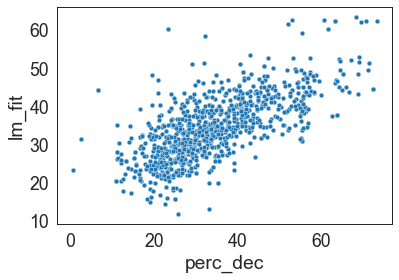

In [74]:
sns.scatterplot(df_valid_lm.perc_dec,df_valid_lm.lm_fit)

### Linear model - plain

In [75]:
df_train_lm, df_valid_lm = df_train.copy(), df_valid.copy()

In [76]:
clf_lm = make_pipeline(filling_na(),LinearRegression() )

In [77]:
clf_lm.fit(df_train_lm.drop(['perc_dec'],axis=1), df_train_lm.perc_dec)

Pipeline(steps=[('filling_na',
                 <__main__.filling_na object at 0x00000220942BE438>),
                ('linearregression', LinearRegression())])

In [78]:
df_train_lm['lm_fit'] = clf_lm.predict(df_train_lm.drop(['perc_dec'],axis=1))

In [79]:
r2_score(df_train_lm.perc_dec,df_train_lm.lm_fit)

0.4726532055837437

In [80]:
df_valid_lm['lm_fit'] = clf_lm.predict(df_valid_lm.drop(['perc_dec'],axis=1))

In [81]:
r2_score(df_valid_lm.perc_dec,df_valid_lm.lm_fit)

0.4671060408663614

In [82]:
clf_lm[1].coef_

array([-5.70481841e-04,  3.49512275e-04,  1.48634733e-05, -2.09207671e+00,
       -3.12163737e-01, -2.52291701e+00, -1.54041023e+00, -6.15044475e-01,
        7.70052578e-01, -6.27485713e-01,  2.12821364e+00,  1.33433104e+00,
        3.10318743e+00,  6.31691215e+00,  1.61894942e-01, -6.83858673e+00,
       -7.19066253e+00, -1.19740823e+00, -1.00596715e+01, -7.02467940e+00,
        8.64467022e+00, -1.39131674e+01, -7.60665687e-01, -5.92716255e+00,
       -1.51207170e+00, -3.20434948e+00,  2.85527503e+00,  1.20733023e+00,
       -8.06150214e+00, -2.68876205e+00, -1.01044249e+01,  2.30940910e-01,
        7.43424999e-01,  2.00545331e-01,  4.39168420e-01,  3.19811681e+00,
       -5.37048630e-01,  2.07116126e-01,  9.13031560e+00,  1.09454736e+01,
       -8.79325347e-01,  1.05474762e+01,  1.00682162e+01,  4.56848008e+00,
        2.07163427e+01,  1.06089017e+01,  5.44191632e+00,  5.19448350e-02,
        8.89124517e+00,  1.50206782e+01,  1.13811977e+01,  1.41909617e+01,
        4.55767160e+00,  

In [83]:
clf_lm[1].intercept_

28.351975370106466

c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='perc_dec', ylabel='lm_fit'>

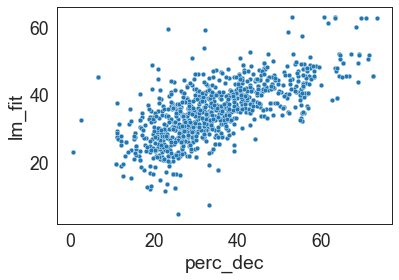

In [84]:
sns.scatterplot(df_valid_lm.perc_dec,df_valid_lm.lm_fit)

#### Funções comuns

In [367]:
def overfit_detect(model, df, param, init_value, end_value, interation_value,param_label='',def_param={},RS=RS):
    lst_etimators = []
    lst_test_score = []
    lst_train_score = []
    for n_param in np.arange(init_value,end_value,interation_value):
        
        cv = 5
        model_params = {param:n_param, 'random_state':RS }
        model_params.update(def_param)
        clf = model(**model_params)
        scores = cross_validate(clf, df.drop(['perc_dec'],axis=1), df.perc_dec, cv=cv,
                                    return_train_score = True, return_estimator = True)
        lst_etimators.append(n_param)
        lst_train_score.append(scores['train_score'].mean())
        lst_test_score.append(scores['test_score'].mean())
    df_estimators = pd.DataFrame({'n_estimators':lst_etimators,'test_score':lst_test_score,'train_score':lst_train_score})
    plt.figure(figsize=(12,7))
    sns.lineplot(data=df_estimators,x='n_estimators',y='test_score',label='Teste')
    sns.lineplot(data=df_estimators,x='n_estimators',y='train_score',label='Treino')
    plt.xlabel(param_label)
    plt.ylabel('R2')

In [ ]:
def permutation_feature_importance(model, X , y):
    results = permutation_importance(model, X, y , n_repeats=10, random_state=RS)
    feature_importance = {X.columns[i]: results.importances_mean[i] for i in range(X.shape[1])}
    return pd.DataFrame({'coluna':feature_importance.keys(),'importancia':feature_importance.values()}).sort_values('importancia',ascending=False)

In [ ]:
def generate_model_and_report(model,params,df_train, df_valid, target_col):
    cv = 5
    regressor = model(random_state=RS) 
    print('Trainning model')
    model_scores = GridSearchCV(estimator=regressor, param_grid=params, cv=cv,
                                return_train_score = True, scoring='r2')\
                            .fit(X=df_train.drop([target_col],axis=1), y=df_train[target_col])
    print('The best parameters found:',model_scores.best_params_ )
    best_index = model_scores.best_index_
    print('Test Score of best model: ', model_scores.cv_results_['mean_test_score'][best_index])
    print('Train Score of best model: ', model_scores.cv_results_['mean_train_score'][best_index])
    print('Mean time to train: ', model_scores.cv_results_['mean_score_time'][best_index])

    best_estimator = scores_lgb.best_estimator_

    valid_scores = best_estimator.predict(df_valid.drop([target_col],axis=1))
    print('Validation Score: ',r2_score(df_valid[target_col],valid_scores))

    plt.figure(figsize=(8,8))
    sns.scatterplot(df_valid[target_col],valid_scores)
    plt.ylabel('Predições')
    plt.xlabel('Desvalorização')
    plt.show()

    ## Calculando importancias
    df_imp = pd.DataFrame({'coluna':df_train.drop([target_col],axis=1).columns,
              'importancia':best_estimator.feature_importances_})\
            .sort_values('importancia',ascending=False)\
            .iloc[:20,:]
    plt.figure(figsize=(12,7))
    sns.barplot(data=df_imp,x='coluna',y='importancia')
    plt.ylabel('Importância')
    plt.xlabel('')
    plt.xticks(rotation=90)
    plt.show()

    feature_importance = permutation_feature_importance(best_estimator, df_train.drop([target_col],axis=1),df_train[target_col])
    plt.figure(figsize=(12,7))
    sns.barplot(data=feature_importance.iloc[0:20,:],x='coluna',y='importancia')
    plt.ylabel('Importância')
    plt.xlabel('')
    plt.xticks(rotation=90)
    plt.show()

    ## importances by shapvalue
    explainer = shap.TreeExplainer(best_estimator)
    shap_values = explainer.shap_values(df_train.drop([target_col],axis=1))
    shap.summary_plot(shap_values, features=df_train.drop([target_col],axis=1), feature_names=df_train.drop([target_col],axis=1).columns)
    return model_scores

### Ligthgbm

In [368]:
df_train_light, df_valid_light = df_train.copy(), df_valid.copy()

In [369]:
df_train_light.head()

,auction_item_min_bid_value,auction_item_market_price,auction_item_km,AIR BAG,ALARME,AR CONDICIONADO,CÂMBIO AUTOMÁTICO,DIREÇÃO HIDRÁULICA,TETO SOLAR,VIDRO ELÉTRICO,SEM_CHAVE,TRINCADO,AVARIADO,SINISTRO,item_age,perc_dec,brand_name_FIAT,brand_name_FORD,brand_name_GM,brand_name_HONDA,brand_name_HYUNDAY,brand_name_JAC,brand_name_JEEP,brand_name_MERCEDES BENZ,brand_name_MMC,brand_name_NISSAN,brand_name_OUTROS,brand_name_PEUGEOT,brand_name_RENAULT,brand_name_TOYOTA,brand_name_VW,brand_name_YAMAHA,color_BRANCA,color_CINZA,color_OUTROS,color_PRATA,color_PRETA,color_VERMELHA,model_208,model_ARGO,model_C3,model_CELTA,model_CG,model_CIVIC,model_CLASSIC,model_COMPASS,model_COROLLA,model_CRUZE,model_DUSTER,model_ECOSPORT,model_FIESTA,model_FIT,model_FOCUS,model_FOX,model_FUSION,model_GOL,model_HB20,model_HB20S,model_J3,model_KA,model_KWID,model_LOGAN,model_NOVO,model_ONIX,model_OUTROS,model_PALIO,model_POLO,model_PRISMA,model_RANGER,model_RENEGADE,model_S10,model_SANDERO,model_SANTA,model_SAVEIRO,model_SIENA,model_SPIN,model_STRADA,model_UNO,model_VERSA,model_VIRTUS,model_VOYAGE,auction_item_gas_type_FLEX,auction_item_gas_type_GASOLINA
1872,33500.0,54352.0,117798.000000,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5.083333,35.604946,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1457,8500.0,19443.0,128675.951965,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,12.333333,27.994651,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1113,18500.0,42734.0,162126.000000,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,10.500000,56.708944,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2297,15500.0,27101.0,212177.000000,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,13.916667,31.736836,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2089,54000.0,90597.0,32731.000000,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.000000,18.319591,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


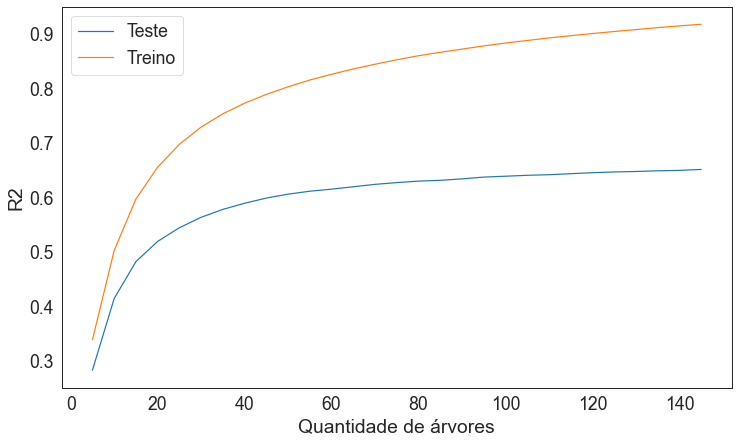

In [370]:
overfit_detect(LGBMRegressor,df_train_light,'n_estimators',5,150,5,'Quantidade de árvores')

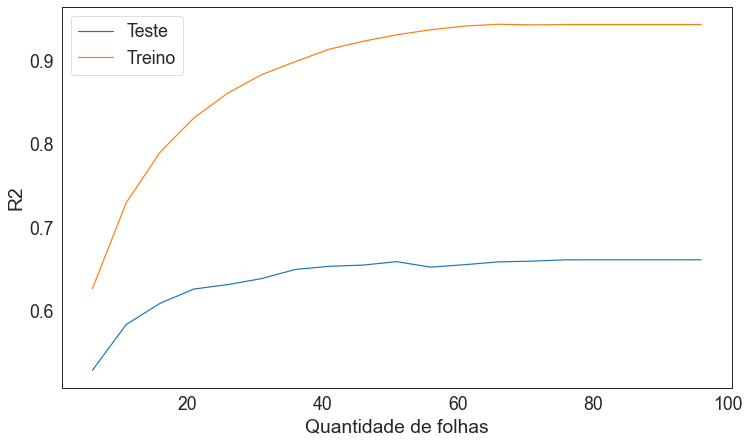

In [371]:
overfit_detect(LGBMRegressor,df_train_light,'num_leaves',1,100,5,'Quantidade de folhas')

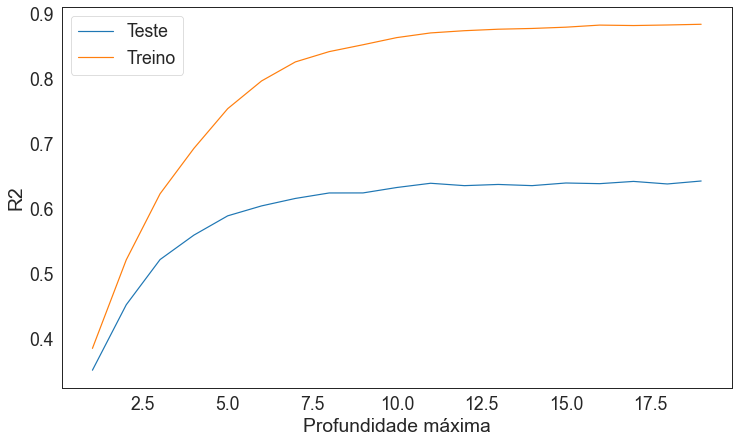

In [372]:
overfit_detect(LGBMRegressor,df_train_light,'max_depth',1,20,1,'Profundidade máxima')

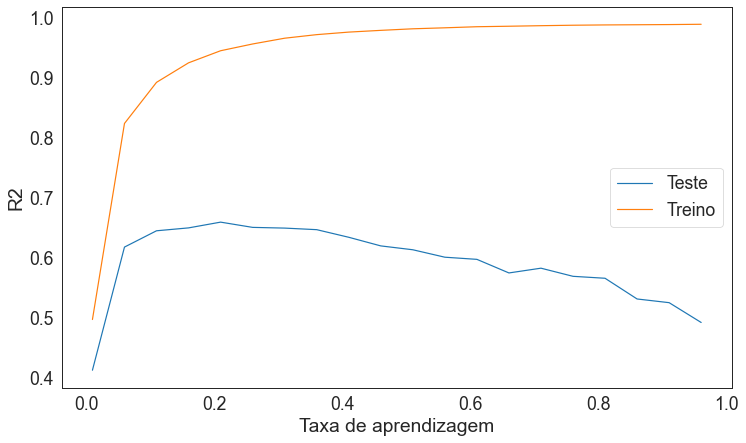

In [373]:
overfit_detect(LGBMRegressor,df_train_light,'learning_rate',0.01,1,0.05,'Taxa de aprendizagem')

In [396]:
grid_params = {
        'num_leaves':[30, 50 ,70],
        'n_estimators':[60 , 90 , 120, 150],
        'max_depth':[2,3,4,5],
        'learning_rate':[0.1 ,0.25 , 0.4 ]
}

Trainning model
The best parameters found: {'learning_rate': 0.25, 'max_depth': 5, 'n_estimators': 150, 'num_leaves': 30}
Test Score of best model:  0.6307808709190976
Train Score of best model:  0.8951109313937498
Mean time to train:  0.008194446563720703
Validation Score:  0.6661813219442718


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


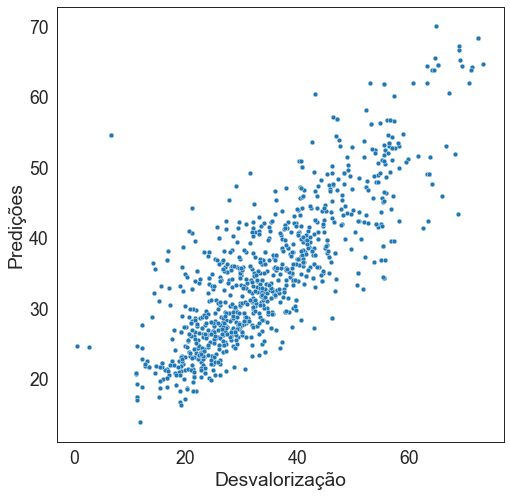

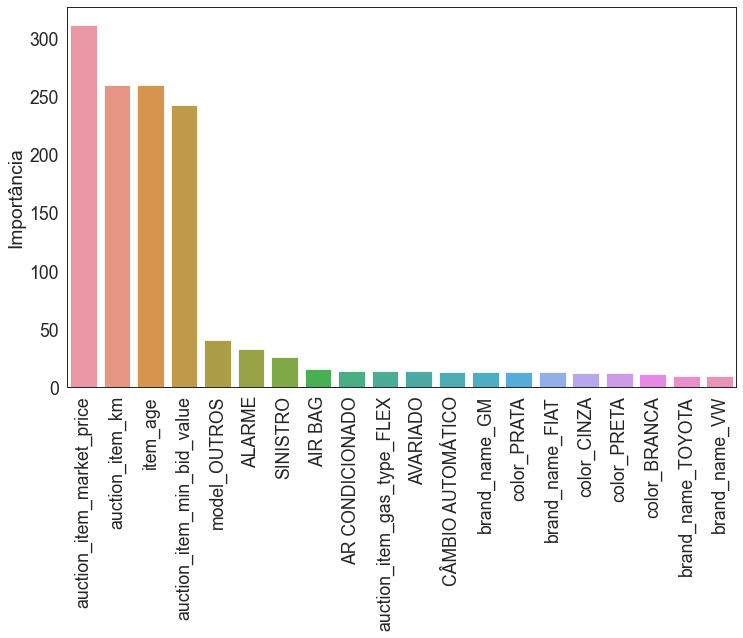

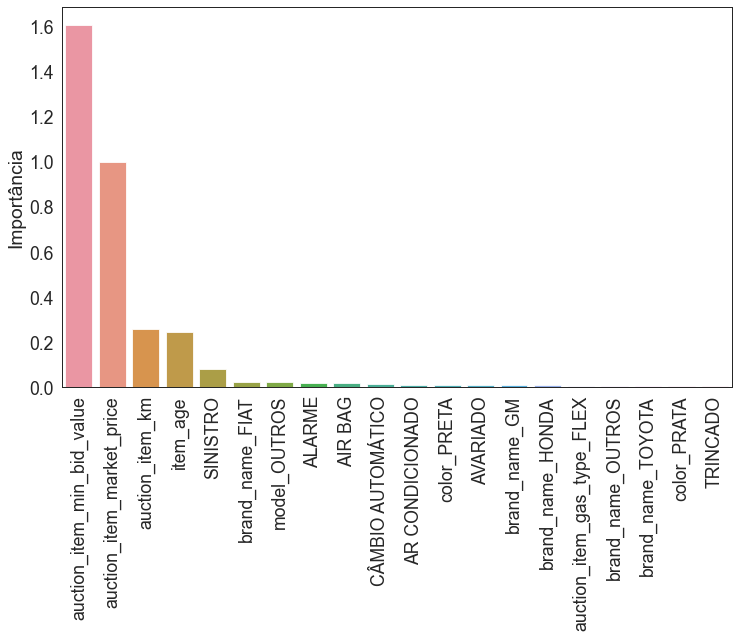

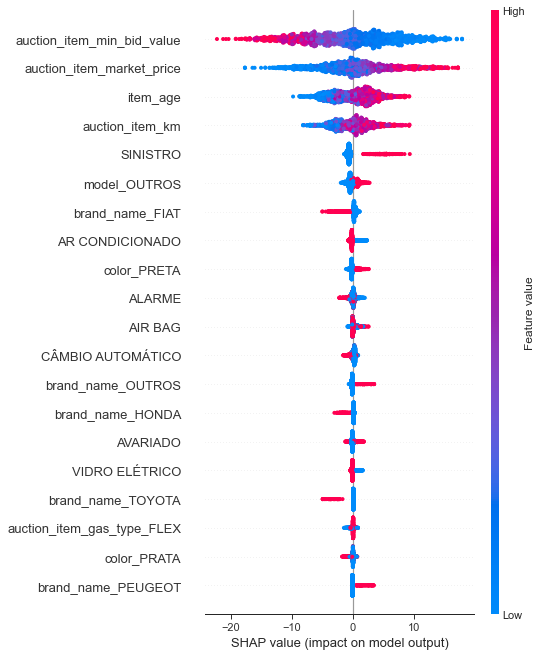

Wall time: 1min 11s


In [397]:
%%time
model_scores = generate_model_and_report(LGBMRegressor,grid_params,df_train_light, df_valid_light, 'perc_dec')

### XGBoost

In [376]:
df_train_xgb, df_valid_xgb = df_train.copy(), df_valid.copy()

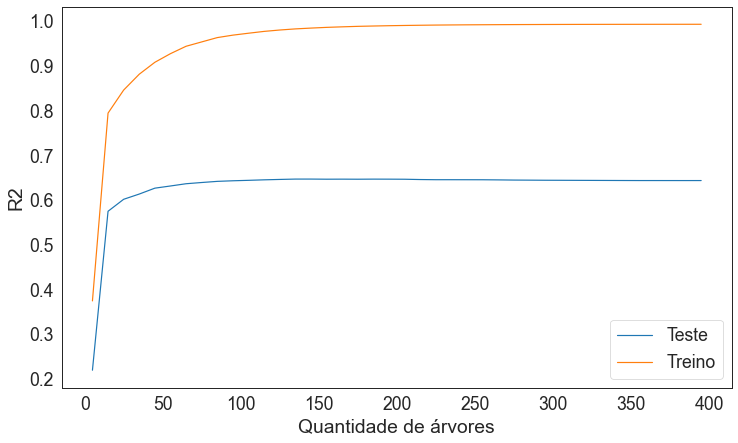

In [377]:
overfit_detect(XGBRegressor,df_train_xgb,'n_estimators',5,400,10,'Quantidade de árvores')

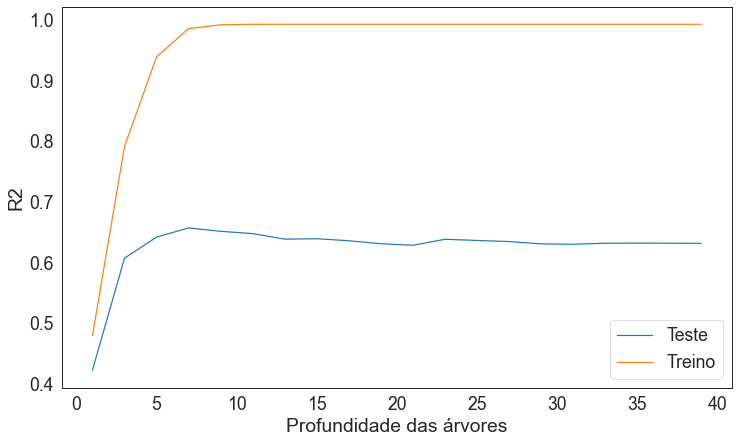

In [379]:
overfit_detect(XGBRegressor,df_train_xgb,'max_depth',1,40,2,'Profundidade das árvores')

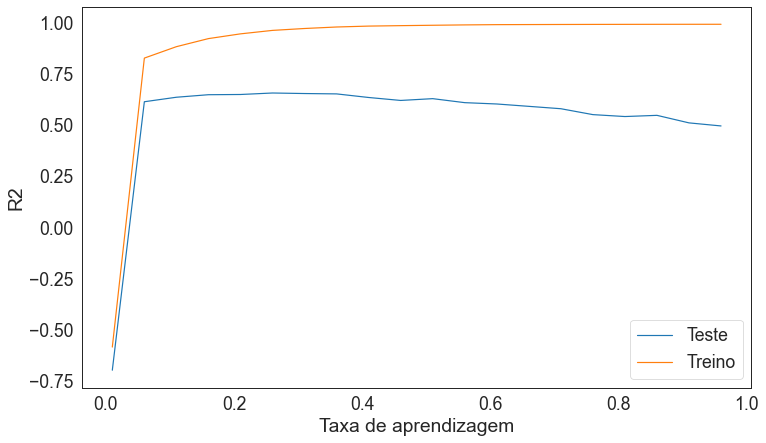

In [380]:
overfit_detect(XGBRegressor,df_train_xgb,'learning_rate',0.01,1,0.05,'Taxa de aprendizagem')

In [398]:
grid_params = {
        'n_estimators':[20, 40 , 60],
        'max_depth':[4,8,12],
        'learning_rate':[0.05,0.1 ,0.2]
}

Trainning model
The best parameters found: {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 60}
Test Score of best model:  0.6529158797523574
Train Score of best model:  0.9624818587149002
Mean time to train:  0.00888199806213379
Validation Score:  0.6661813219442718


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


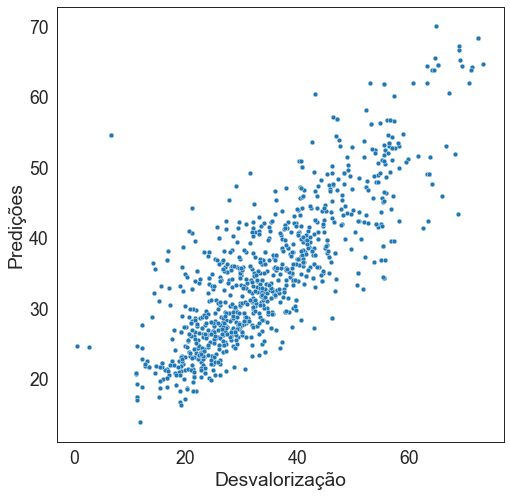

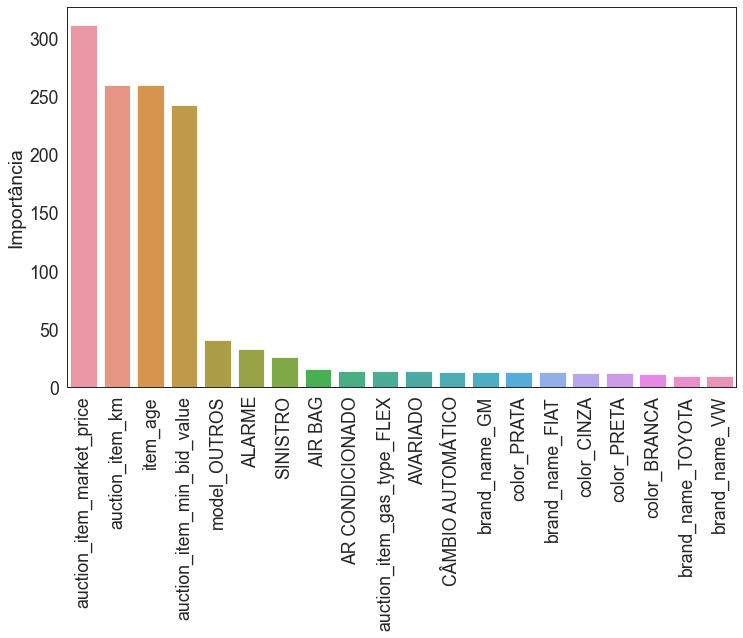

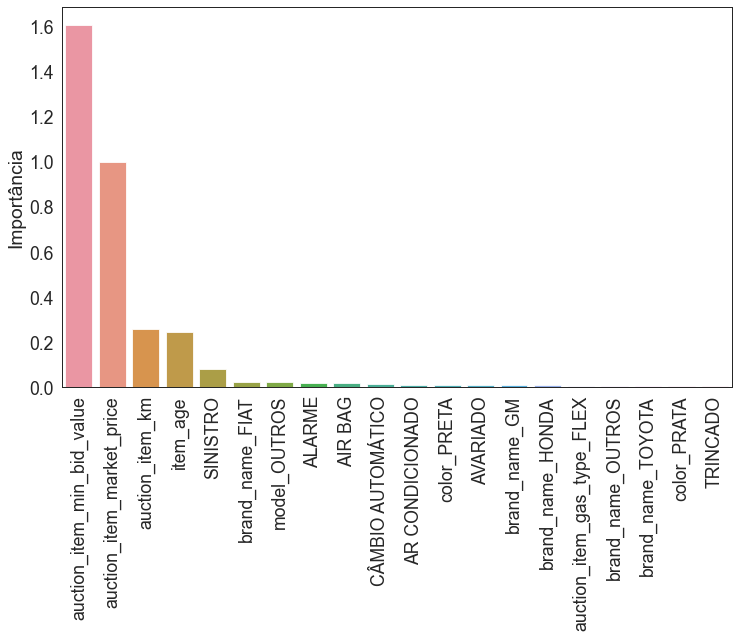

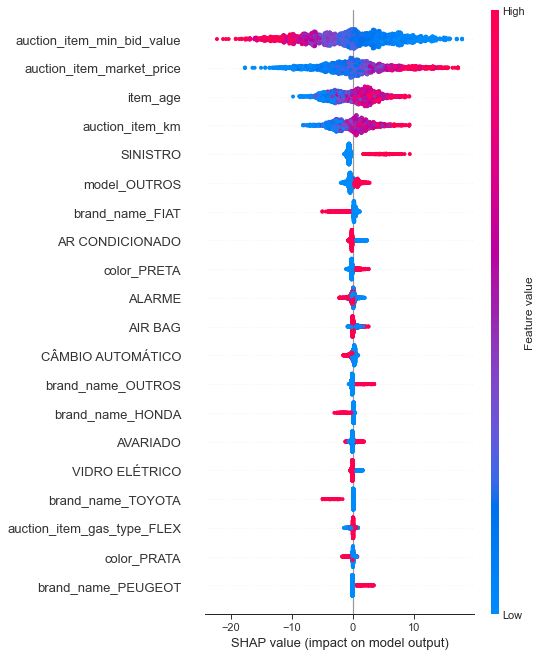

Wall time: 49.1 s


In [399]:
%%time
model_scores = generate_model_and_report(XGBRegressor,grid_params,df_train_xgb, df_valid_xgb, 'perc_dec')

### Random Forest

In [383]:
df_train_rfr, df_valid_rfr = df_train.copy(), df_valid.copy()

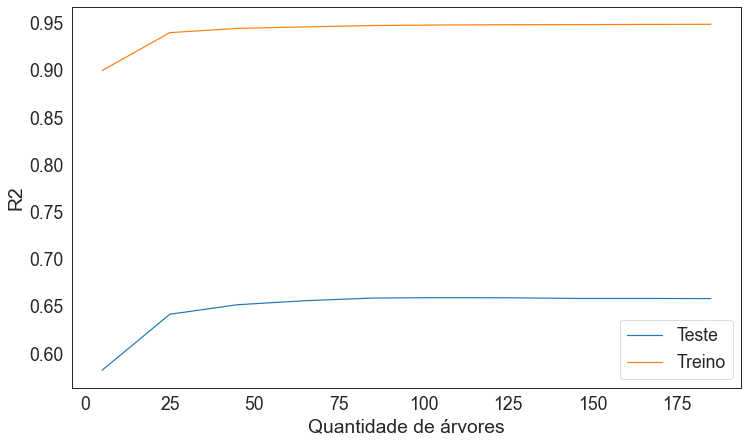

In [392]:
overfit_detect(RandomForestRegressor,df_train_rfr,'n_estimators',5,200,20,'Quantidade de árvores')

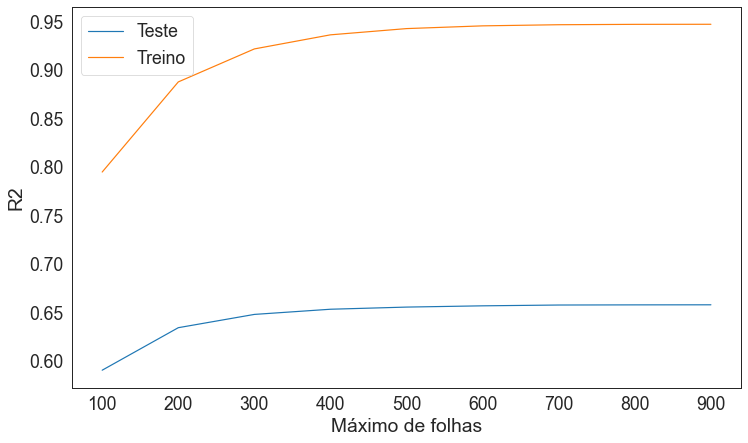

In [391]:
overfit_detect(RandomForestRegressor,df_train_rfr,'max_leaf_nodes',0,1000,100,'Máximo de folhas')

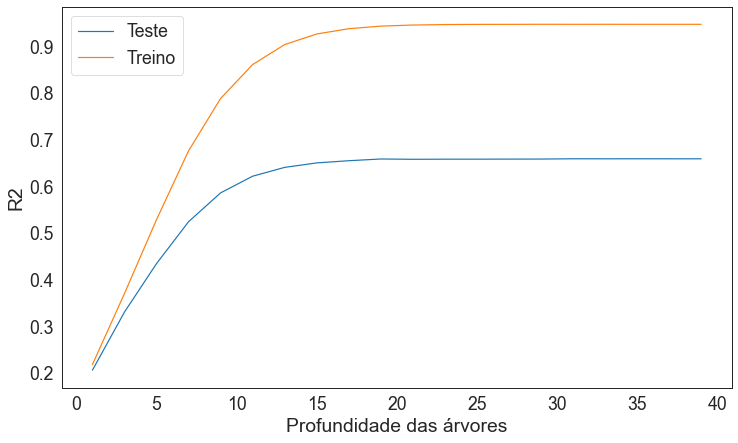

In [386]:
overfit_detect(RandomForestRegressor,df_train_rfr,'max_depth',1,40,2,'Profundidade das árvores')

In [393]:
grid_params = {
        'max_leaf_nodes':[100, 250, 500],
        'n_estimators':[20, 40 ,60 , 80 ],
        'max_depth':[8, 12 ,16 ,20]
}

Trainning model
The best parameters found: {'max_depth': 20, 'max_leaf_nodes': 500, 'n_estimators': 80}
Test Score of best model:  0.6543965744960024
Train Score of best model:  0.9406557819886064
Mean time to train:  0.021134614944458008
Validation Score:  0.6661813219442718


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


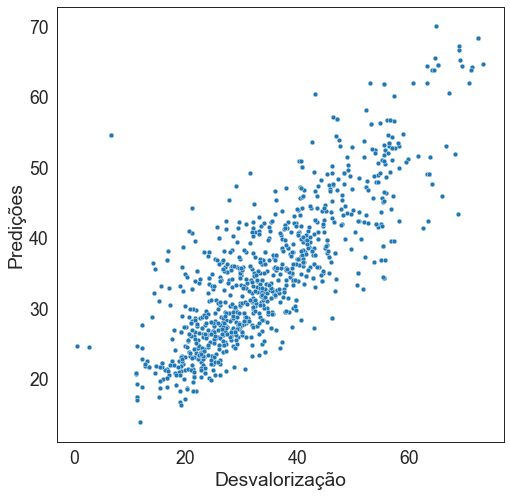

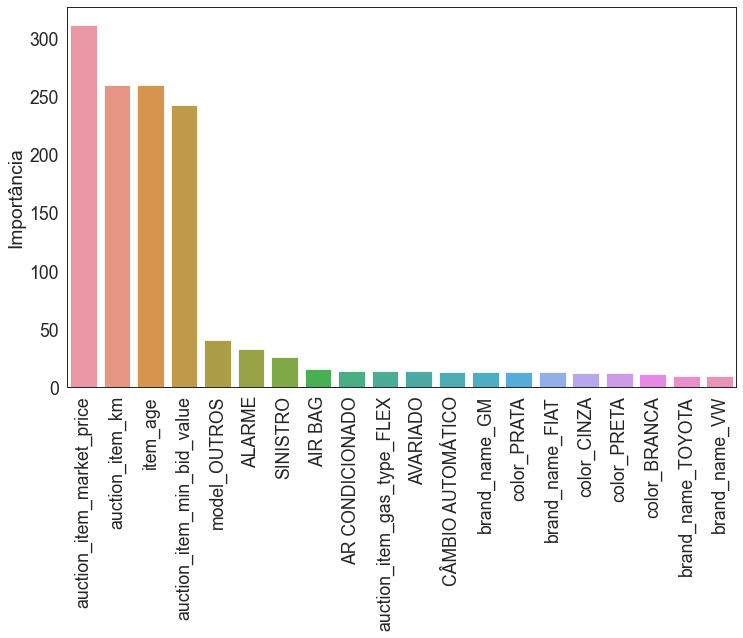

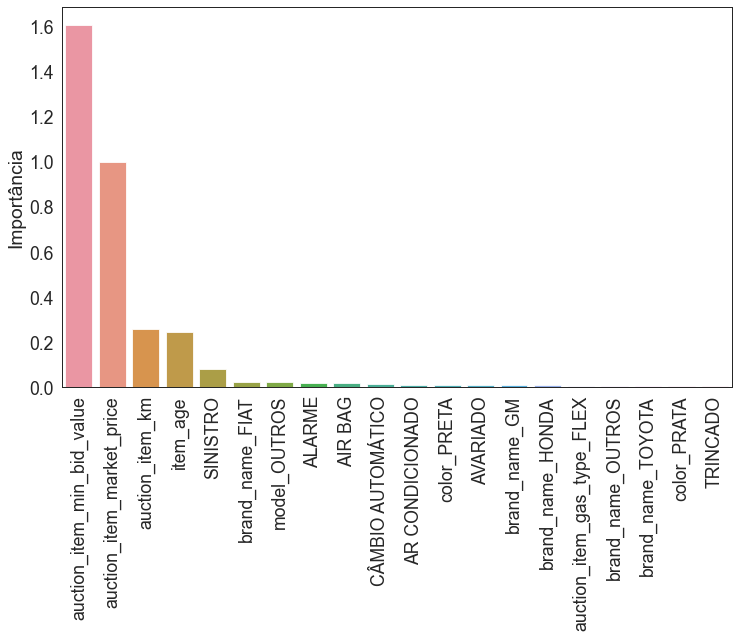

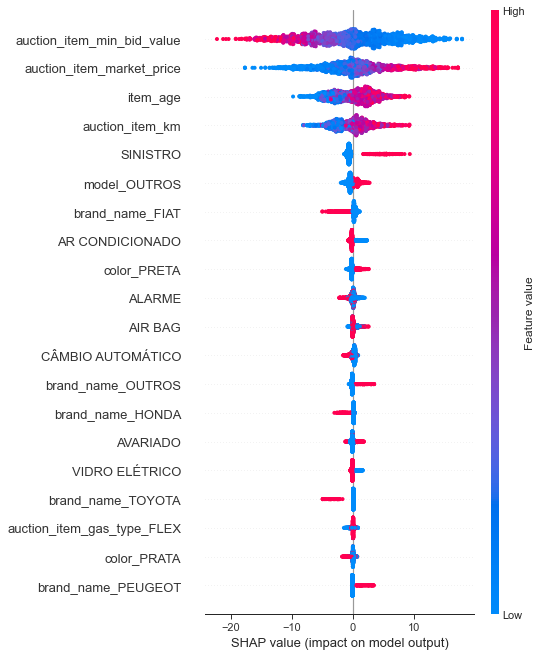

Wall time: 3min 32s


In [395]:
%%time
model_scores = generate_model_and_report(RandomForestRegressor,grid_params,df_train_rfr, df_valid_rfr, 'perc_dec')